In [5]:
import os
import re
import nibabel as nib
import numpy as np
import h5py

import matplotlib.pyplot as plt
from scipy import stats

In [6]:
def make_groups(hdf5_file):
    with h5py.File(hdf5_file, 'a') as f:
        training = f.create_group('training')
        training.create_group('image')
        training.create_group('seg')

        validation = f.create_group('validation')
        validation.create_group('image')
        validation.create_group('seg')

        test_seg = f.create_group('test_seg')
        test_seg.create_group('image')
        test_seg.create_group('seg')

        test_lm = f.create_group('test_lm')
        test_lm.create_group('image')
        test_lm.create_group('landmarks')


In [7]:

def convert_to_h5py(directory, hdf5_file):
    # One loop for training + validation
    val_size = 30
    seg_dim = 36
    max_val = 279.82879638671875
    i = 0
    for root, dirs, files in os.walk(directory+'/train'):
        dirs.sort() # Sort directories in ascending order
        for file in files:
            if file.endswith("nii.gz"):
                img = nib.load(os.path.join(root, file)).get_fdata()
                # my preprocessing
                img = np.transpose(img, (0, 2, 1))
                img = img[::-1,:,::-1]

                with h5py.File(hdf5_file, 'a') as f:
                        f.attrs['shape'] = img.shape
                        if i < 30:
                            group = 'validation'
                            k = i
                        else:
                            group = 'training'
                            k = i - val_size

                        if file.endswith("norm.nii.gz"):
                            f[group+'/image'].create_dataset(str(k), data=img)
                        elif file.endswith("seg35.nii.gz"):
                            f[group+'/seg'].create_dataset(str(k), data=img)
                            i += 1 # works bc seg35 is always after norm
                        else:
                            raise ValueError('File name not recognized')
    with h5py.File(hdf5_file, 'a') as f:
        f['training'].attrs['N'] = i - val_size
        f['training'].attrs['seg_dim'] = seg_dim
        f['validation'].attrs['N'] = val_size
        f['validation'].attrs['seg_dim'] = seg_dim

    # one loop for test_seg
    group = 'test_seg'
    i = 0
    for root, dirs, files in os.walk(directory+"/test/neurite"):
        dirs.sort()
        for file in files:
            if file.endswith("nii.gz"):
                    img = nib.load(os.path.join(root, file)).get_fdata()
                    # my preprocessing
                    img = np.transpose(img, (0, 2, 1))
                    img = img[::-1,:,::-1]

                    with h5py.File(hdf5_file, 'a') as f:
                        if file.endswith("norm.nii.gz"):
                            f[group+'/image'].create_dataset(str(i), data=img)
                        elif file.endswith("seg35.nii.gz"):
                            f[group+'/seg'].create_dataset(str(i), data=img)
                            i += 1 # works bc seg35 is always after norm
                        else:
                            raise ValueError('File name not recognized')
    with h5py.File(hdf5_file, 'a') as f:
            f['test_seg'].attrs['N'] = i
            f['test_seg'].attrs['seg_dim'] = seg_dim
                        
    # one loop for test_lm
    group = 'test_lm'
    i = 0
    for root, dirs, files in os.walk(directory+"/test/sub-lms-oasis"):
        files.sort() # Sort the files in ascending order
        for file in files:
            if file.endswith("T1w_oasis.nii.gz"):
                img = nib.load(os.path.join(root, file)).get_fdata()
                # min max normalization
                img = img / max_val
                with h5py.File(hdf5_file, 'a') as f:
                    f[group+'/image'].create_dataset(str(i), data=img)
            elif file.endswith("lms.txt"):
                landmarks = np.genfromtxt(os.path.join(root, file),delimiter=' ')
                with h5py.File(hdf5_file, 'a') as f:
                    f[group+'/landmarks'].create_dataset(str(i), data=landmarks)
                i += 1 # works bc lms.txt are always after T1w_oasis
    with h5py.File(hdf5_file, 'a') as f:
        f['test_lm'].attrs['N'] = i


In [8]:
hdf5_file = "LM_OASIS.h5"
make_groups(hdf5_file)
convert_to_h5py(".", hdf5_file)

In [3]:
train_img = nib.load("train/neurite-oasis.v1.0/OASIS_OAS1_0001_MR1/aligned_norm.nii.gz").get_fdata()
train_seg = nib.load("train/neurite-oasis.v1.0/OASIS_OAS1_0001_MR1/aligned_seg35.nii.gz").get_fdata()
test_img_seg = nib.load("test/neurite/OASIS_OAS1_0086_MR1/aligned_norm.nii.gz").get_fdata()
test_img_lm = nib.load("test/sub-lms-oasis/sub-0086_T1w_oasis.nii.gz").get_fdata()

# HACK: transpose and flip to match the orientation of the atlas
# This is correct, but why?
test_img_seg = np.transpose(test_img_seg, (0, 2, 1))
test_img_seg = test_img_seg[::-1,:,::-1]

# min max preprocess the lm images
test_img_lm = test_img_lm / 279.82879638671875

print(train_img.shape)
print(train_seg.shape)
print(test_img_seg.shape)
print(test_img_lm.shape)

(160, 192, 224)
(160, 192, 224)
(160, 224, 192)
(160, 224, 192)


In [43]:
# normalize the data
directory = "test/neurite"
seg_min = []
seg_max = []
for root, dirs, files in os.walk(directory):
    # print(root, dirs, files)
    dirs.sort() # Sort directories in ascending order
    for file in files:
        if file.endswith("norm.nii.gz"):
            print(file)
            img = nib.load(os.path.join(root, file)).get_fdata()
            seg_min.append(np.min(img))
            seg_max.append(np.max(img))

# do the same for the landmarks
directory = "test/sub-lms-oasis"
lm_min = []
lm_max = []
for root, dirs, files in os.walk(directory):
    print(root, dirs, files)
    files.sort() # Sort the files in ascending order
    for file in files:
        if file.endswith("T1w_oasis.nii.gz"):
            print(file)
            img = nib.load(os.path.join(root, file)).get_fdata()
            lm_min.append(np.min(img))
            lm_max.append(np.max(img) / 279.82879638671875)

aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
aligned_norm.nii.gz
test/sub-lms-oasis [] ['sub-0398_T1w_oasis.nii.gz', 'sub-0114_lms.txt', 'sub-0117_lms_oasis.nii.gz', 'sub-0274_lms_oasis.nii.gz', 'sub-0200_T1w_oasis.nii.gz', 'sub-0371_lms.txt', 'sub-0177_T1w_oasis.nii.gz', 'sub-0395_lms_oasis.nii.gz', 'sub-0357_lms.txt', 'sub-0255_lms_oasis.nii.gz', 'sub-0343_lms_oasis.nii.gz', 'sub-0145_lms_oasis.nii.gz', 'sub-0456_lms_oasis.nii.gz', 'sub-0456_lms.txt', 'sub-02

seg min: 0.0
seg max: 0.9450980424880981
lm min: 0.0
lm max: 1.0


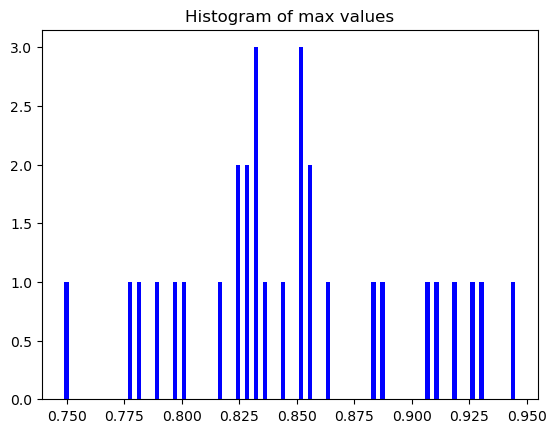

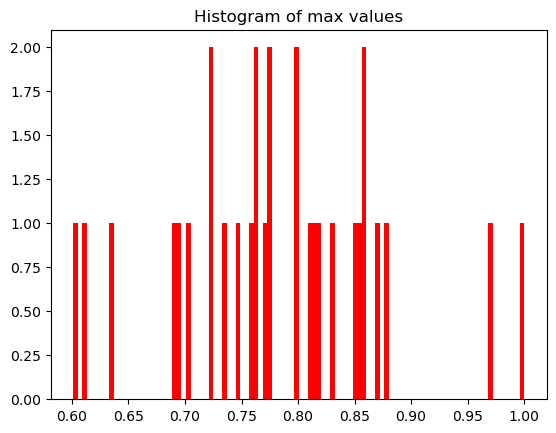

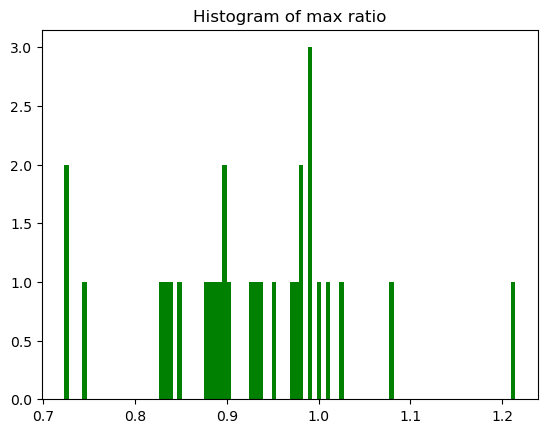

In [44]:
# print the min max
print("seg min:", np.min(seg_min))
print("seg max:", np.max(seg_max))
print("lm min:", np.min(lm_min))
print("lm max:", np.max(lm_max))

# histogram of max values
plt.hist(seg_max, bins=100, color='b')
plt.title("Histogram of max values")
plt.show()

plt.hist(lm_max, bins=100, color='r')
plt.title("Histogram of max values")
plt.show()

max_ratio = np.array(lm_max) / np.array(seg_max)
plt.hist(max_ratio, bins=100, color='g')
plt.title("Histogram of max ratio")
plt.show()

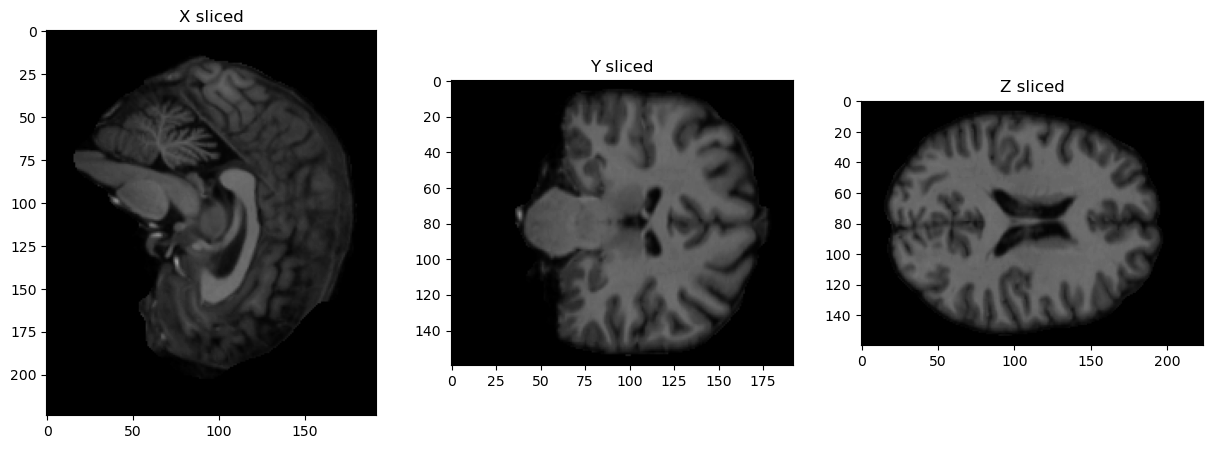

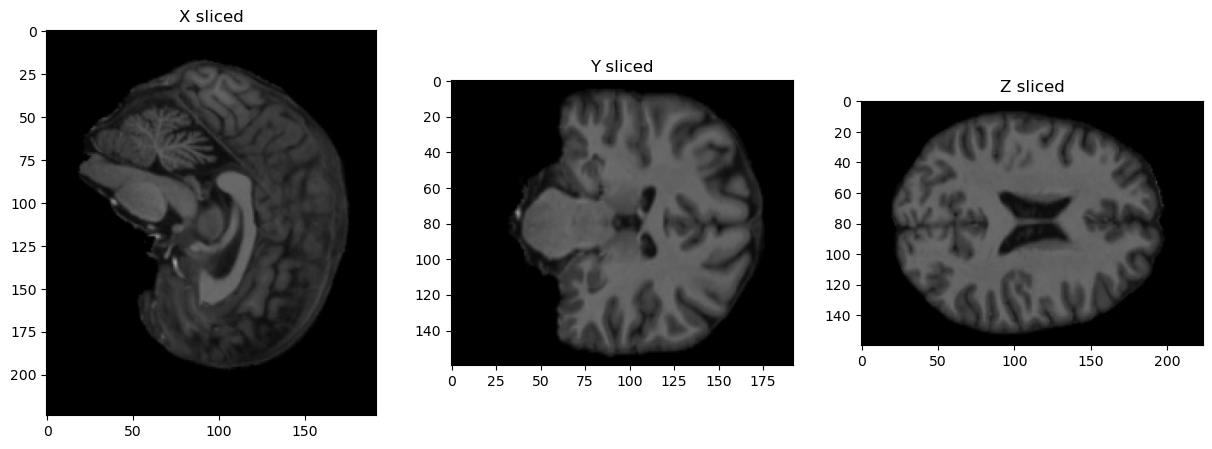

In [46]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(test_img_seg[80, :, :], cmap='gray', vmin=0, vmax=1)
# axs[0].scatter(landmarks[:, 2], landmarks[:, 1], c='r')
axs[0].set_title('X sliced')

axs[1].imshow(test_img_seg[:, 96, :], cmap='gray', vmin=0, vmax=1)
# axs[1].scatter(landmarks[:, 2], landmarks[:, 0], c='r')
axs[1].set_title('Y sliced')

axs[2].imshow(test_img_seg[:, :, 112], cmap='gray', vmin=0, vmax=1)
# axs[2].scatter(landmarks[:, 1], landmarks[:, 0], c='r')
axs[2].set_title('Z sliced')
plt.show()

# do the same for test_img_lm
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(test_img_lm[80, :, :], cmap='gray', vmin=0, vmax=1)
# axs[0].scatter(landmarks[:, 2], landmarks[:, 1], c='r')
axs[0].set_title('X sliced')

axs[1].imshow(test_img_lm[:, 96, :], cmap='gray', vmin=0, vmax=1)
# axs[1].scatter(landmarks[:, 2], landmarks[:, 0], c='r')
axs[1].set_title('Y sliced')

axs[2].imshow(test_img_lm[:, :, 112], cmap='gray', vmin=0, vmax=1)
# axs[2].scatter(landmarks[:, 1], landmarks[:, 0], c='r')
axs[2].set_title('Z sliced')
plt.show()